 # Secure Water Treatment System

In [3]:
#Libraries 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

## Dataset Preparation



In [4]:
# Load data (Normal+Attack)
normal_df = pd.read_csv("normal.csv")
attack_df = pd.read_csv("attack.csv")


normal_df["Label"] = 0   # 0 = Normal
attack_df["Label"] = 1   # 1 = Attack

df = pd.concat([normal_df, attack_df], ignore_index=True)

print("Dataset shape:", df.shape)

Dataset shape: (1441719, 54)


## Data Cleaning



In [5]:
if "Timestamp" in df.columns:
    df.drop(columns=["Timestamp"], inplace=True)


df["Label"] = df["Label"].astype(int)


print("Missing values:", df.isnull().sum().sum())


Missing values: 6942600


## Descriptive Statistics


In [6]:
stats = df.describe().T[["mean", "std", "min", "max"]]
print(stats.head())

              mean         std       min          max
FIT101    1.806108    1.153932    0.0000     2.760145
LIT101  593.120048  123.932458  120.6237  1000.000000
 MV101    1.665335    0.482323    0.0000     2.000000
P101      1.730916    0.443484    1.0000     2.000000
P102      1.002168    0.046507    1.0000     2.000000


## Correlation Analysis


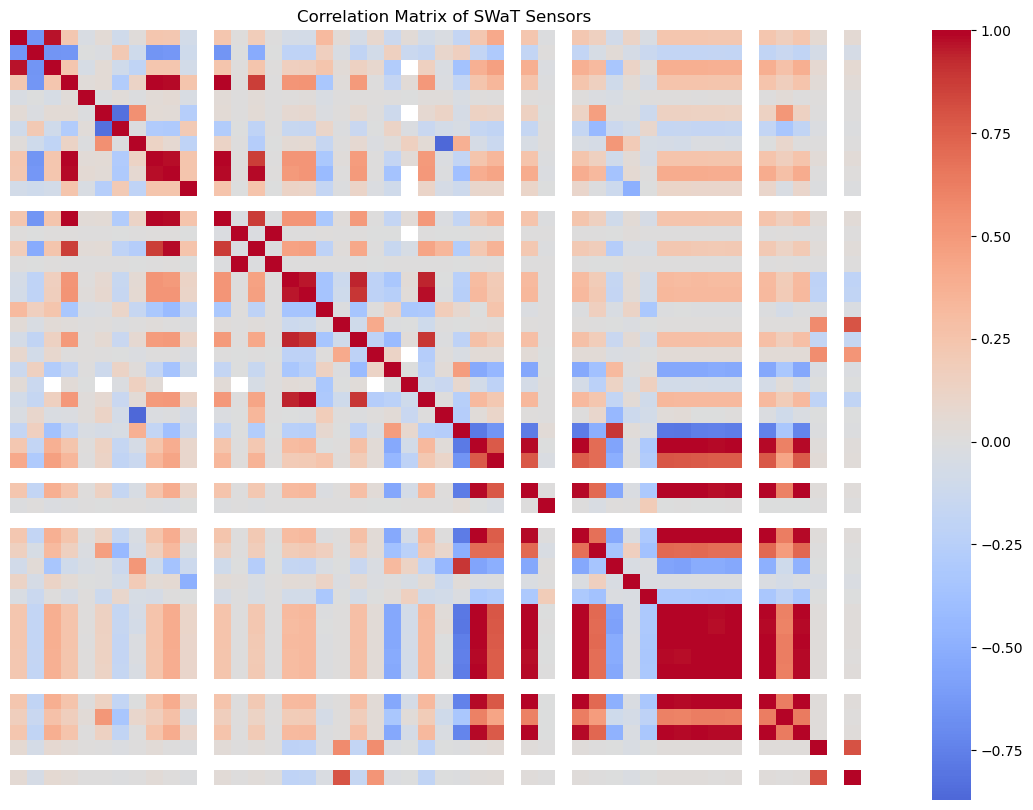

In [7]:
# Correlation Heatmap between sensors
plt.figure(figsize=(14,10))

numeric_df = df.drop(columns=["Label"]).select_dtypes(include="number")
correlation_matrix = numeric_df.corr()

sns.heatmap(
    correlation_matrix,
    cmap="coolwarm",
    center=0,
    xticklabels=False,  
    yticklabels=False
)

plt.title("Correlation Matrix of SWaT Sensors")
plt.show()

## Distribution Analysis: Normal vs Attack



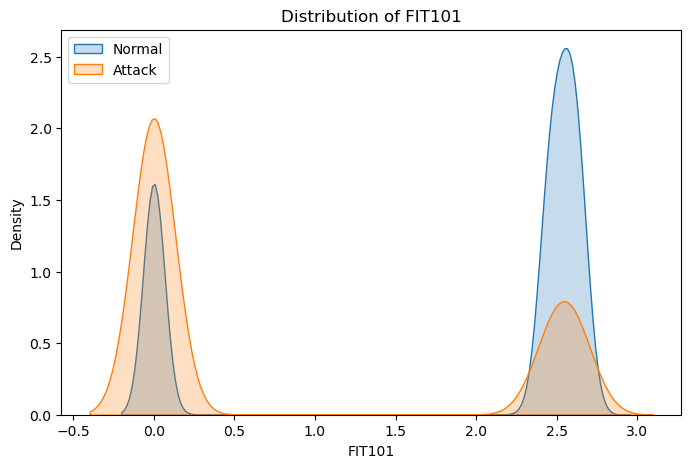

In [8]:
sensor_name = df.select_dtypes(include="number").columns[0]

plt.figure(figsize=(8,5))

sns.kdeplot(
    df[df["Label"] == 0][sensor_name],
    label="Normal",
    fill=True
)

sns.kdeplot(
    df[df["Label"] == 1][sensor_name],
    label="Attack",
    fill=True
)

plt.title(f"Distribution of {sensor_name}")
plt.legend()
plt.show()


## Data Preprocessing and Standardization


In [9]:
# Prepare data
X = df.drop(columns=["Label"]).select_dtypes(include="number")

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Anomaly Detection Using Isolation Forest


In [10]:
# Initialize Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.1,
    random_state=42
)


df["Anomaly"] = iso_forest.fit_predict(X_scaled)

# Convert output:
#  1  -> Normal
# -1  -> Anomaly
df["Anomaly"] = df["Anomaly"].map({1: 0, -1: 1})




## Export Dataset for Power BI Visualization


In [11]:
powerbi_df = df.copy()
powerbi_df.rename(columns={
    "Label": "True_Label",
    "Anomaly": "Detected_Anomaly"
}, inplace=True)


powerbi_df.to_csv("swat_powerbi_dataset.csv", index=False)

print("Power BI dataset exported successfully!")


Power BI dataset exported successfully!


## Model Evaluation



In [12]:
print("Confusion Matrix:")
print(confusion_matrix(df["Label"], df["Anomaly"]))

print("\nClassification Report:")
print(classification_report(df["Label"], df["Anomaly"]))

Confusion Matrix:
[[1282719  104379]
 [  14828   39793]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.96   1387098
           1       0.28      0.73      0.40     54621

    accuracy                           0.92   1441719
   macro avg       0.63      0.83      0.68   1441719
weighted avg       0.96      0.92      0.93   1441719



## Visualization of Detected Anomalies



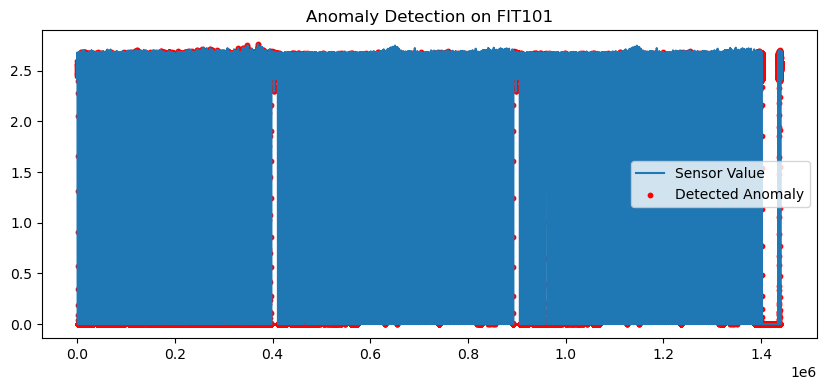

In [13]:
plt.figure(figsize=(10,4))
plt.plot(df[sensor_name].values, label="Sensor Value")
plt.scatter(
    df.index[df["Anomaly"] == 1],
    df[sensor_name][df["Anomaly"] == 1],
    color="red",
    label="Detected Anomaly",
    s=10
)

plt.title(f"Anomaly Detection on {sensor_name}")
plt.legend()
plt.show()